### ShreyPy Tractography
#### I mix and match stuff from multiple sources and pray they work 

In [1]:
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from matplotlib import cm

import os,sys,glob,numpy as np, pandas as pd

from skimage import measure

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi

%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from nilearn.image import index_img

from dipy.core.gradients import gradient_table
from dipy.reconst import shm
from dipy.direction import peaks

from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion
from dipy.io.dpy import Dpy


import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

from dipy.tracking.distances import approx_polygon_track

In [259]:
import nilearn

In [210]:
# Directory

data_direc = '/nethome/kcni/hharita/Data/HCP_WB_Tutorial_TEST/HCP_WB_Tutorial_1.0'

# Left Hemisphere MID-THICKNESS Surface file
mtleft_file = data_direc + '/Q1-Q6_R440.L.midthickness.32k_fs_LR.surf.gii'

# Left Hemisphere INFLATED Surface file
infleft_file = data_direc + '/Q1-Q6_R440.L.inflated.32k_fs_LR.surf.gii'

# Left Hemisphere VERY INFLATED Surface file 

vinfleft_file = data_direc + '/Q1-Q6_R440.L.very_inflated.32k_fs_LR.surf.gii'

# Left Hemisphere PIAL Surface file
pialleft_file = data_direc + '/Q1-Q6_R440.L.pial.32k_fs_LR.surf.gii'

# Left Hemisphere FLAT Surface file

flatleft_file = data_direc + '/Q1-Q6_R440.L.flat.32k_fs_LR.surf.gii'

# curved surface 

curv_file = data_direc + '/Q1-Q6_R440.All.curvature.32k_fs_LR.dscalar.nii'

# sulcus file

sulc_file = data_direc + '/Q1-Q6_R440.All.sulc.32k_fs_LR.dscalar.nii'

# Left hemisphere SPHERICAL surface file

sphere_file = data_direc + '/Q1-Q6_R440.L.sphere.32k_fs_LR.surf.gii'

# for the cifti-2 converted label file

anotherdir = '/external/rprshnas01/kcni/hharita/Data/HCP_WB_Tutorial_TEST/HCP_WB_Tutorial_1.0'
label_file = anotherdir + '/parcellations_VGD11b.32k_fs_LR_c2.dlabel.nii'

# Left Hemisphere PIAL Surface file
pialright_file = data_direc + '/Q1-Q6_R440.R.pial.32k_fs_LR.surf.gii'

# Right Hemisphere MID-THICKNESS Surface file
mtright_file = data_direc + '/Q1-Q6_R440.R.midthickness.32k_fs_LR.surf.gii'

In [211]:
# Mid-thickness surface (right)
r_img_mt = nib.load(mtright_file) 
r_mt_vtx = r_img_mt.darrays[0].data
r_mt_tri = r_img_mt.darrays[1].data

In [207]:
# read in the loaded surfaces ...

# Mid-thickness surface (left)
img_mt = nib.load(mtleft_file) 
mt_vtx = img_mt.darrays[0].data
mt_tri = img_mt.darrays[1].data

# Pial surface
img_pial = nib.load(pialleft_file)
pial_vtx = img_pial.darrays[0].data
pial_tri = img_pial.darrays[1].data

# Inflated surface
img_inf = nib.load(infleft_file)
inf_vtx = img_inf.darrays[0].data
inf_tri = img_inf.darrays[1].data

# Inflated surface
img_vinf = nib.load(vinfleft_file)
vinf_vtx = img_vinf.darrays[0].data
vinf_tri = img_vinf.darrays[1].data

# Flat surface 

img_flat = nib.load(flatleft_file)
flat_vtx = img_flat.darrays[0].data
flat_tri = img_flat.darrays[1].data

# Spherical surface

img_sphere = nib.load(sphere_file)
sphere_vtx = img_sphere.darrays[0].data
sphere_tri = img_sphere.darrays[1].data

In [212]:
# mid-thickness (right)
df_r_mt_vtx = pd.DataFrame(r_mt_vtx, columns=['x','y','z'])

In [208]:
# mid-thickness (left)
df_mt_vtx = pd.DataFrame(mt_vtx, columns=['x','y','z'])

# pial
df_pial_vtx = pd.DataFrame(pial_vtx, columns=['x','y','z'])

# inflated 
df_inf_vtx = pd.DataFrame(inf_vtx, columns=['x','y','z'])

# very inflated
df_vinf_vtx = pd.DataFrame(vinf_vtx, columns=['x','y','z'])

# flat 
df_flat_vtx = pd.DataFrame(flat_vtx, columns=['x','y','z'])

# spherical
df_sphere_vtx = pd.DataFrame(sphere_vtx, columns=['x','y','z'])

In [2]:
# Load the relevant files

In [12]:
bvecs_file = '/external/rprshnas01/public_datasets/HCP/HCP_S900/151526/T1w/Diffusion/bvecs'
bvecs_dat = np.loadtxt(bvecs_file)

bvals_file = '/external/rprshnas01/public_datasets/HCP/HCP_S900/151526/T1w/Diffusion/bvals'
bvals_dat = np.loadtxt(bvals_file)


# laoding a dwi file is similar to loading in a dconn file ...

dwi_file = '/external/rprshnas01/public_datasets/HCP/HCP_S900/151526/T1w/Diffusion/data.nii.gz'
dwi_img = nib.load(dwi_file)
dwi_dat = dwi_img.get_data()

b0_img = index_img(dwi_img,0)

# load brain mask file ...

nbm_file = '/external/rprshnas01/public_datasets/HCP/HCP_S900/151526/T1w/Diffusion/nodif_brain_mask.nii.gz'
nbm_img = nib.load(nbm_file)
nbm_dat = nbm_img.get_data()

In [225]:
nbm_dat.shape

(145, 174, 145)

In [226]:
np.unique(nbm_dat)

array([0., 1.], dtype=float32)

In [13]:
gtab = gradient_table(bvals_dat, bvecs_dat)

affine = dwi_img.affine

In [47]:
np.unique(nbm_dat)

array([0., 1.], dtype=float32)

In [14]:
%%time
csamodel = shm.CsaOdfModel(gtab, 6)
csapeaks = peaks.peaks_from_model(model=csamodel,
                                  data=dwi_dat,
                                  sphere=peaks.default_sphere,
                                  relative_peak_threshold=.8,
                                  min_separation_angle=45,
                                  mask=nbm_dat.astype(bool))

CPU times: user 7min 39s, sys: 33.6 s, total: 8min 13s
Wall time: 8min 13s


In [15]:
aff = b0_img.affine

In [ ]:
utils.seeds_from_mask()

In [16]:
seeds = utils.seeds_from_mask(nbm_dat,aff,density=[2,2,2])

In [17]:
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion


In [18]:
stopping_criterion = BinaryStoppingCriterion(nbm_dat)


In [19]:
%%time
streamline_generator = LocalTracking(csapeaks, stopping_criterion, seeds, affine=aff, step_size=0.5)

CPU times: user 0 ns, sys: 109 ms, total: 109 ms
Wall time: 116 ms


In [20]:
%%time
# This step takes 30 minutes to run!
streamlines = Streamlines(streamline_generator)

CPU times: user 21min 46s, sys: 28min 13s, total: 50min
Wall time: 50min 11s


In [21]:
streamlines

ArraySequence([array([[ 68.00358245, -42.14895317,   1.34099479],
       [ 67.83501254, -42.59158597,   1.50118339],
       [ 67.66700656, -43.04228073,   1.63774193],
       [ 67.5       , -43.5       ,   1.75      ],
       [ 67.33299344, -43.95771927,   1.86225807]]), array([[ 67.23159143, -43.35130036,   1.35522759],
       [ 67.5       , -43.5       ,   1.75      ],
       [ 67.76840857, -43.64869964,   2.14477241],
       [ 68.08057095, -43.76672392,   2.51709609]]), array([[ 6.73329934e+01, -4.39577193e+01,  1.86225807e+00],
       [ 6.75000000e+01, -4.35000000e+01,  1.75000000e+00],
       [ 6.71264039e+01, -4.31697554e+01,  1.78693834e+00],
       [ 6.67797186e+01, -4.28094765e+01,  1.78403412e+00],
       [ 6.64659918e+01, -4.24212310e+01,  1.75503438e+00],
       [ 6.61760050e+01, -4.20146539e+01,  1.73048588e+00],
       [ 6.59019351e+01, -4.15965543e+01,  1.72162639e+00],
       [ 6.56361783e+01, -4.11756209e+01,  1.76840608e+00],
       [ 6.53878007e+01, -4.07756719e+01, 

In [22]:
len(streamlines)

1894941

In [27]:
streamlines[0]

array([[ 68.00358245, -42.14895317,   1.34099479],
       [ 67.83501254, -42.59158597,   1.50118339],
       [ 67.66700656, -43.04228073,   1.63774193],
       [ 67.5       , -43.5       ,   1.75      ],
       [ 67.33299344, -43.95771927,   1.86225807]])

In [23]:
%%time
# This step take 3 minutes to run. 
streamlines_ds = np.array([approx_polygon_track(s) for s in streamlines])

CPU times: user 3min 22s, sys: 9.54 s, total: 3min 31s
Wall time: 3min 31s


In [26]:
streamlines_ds[2]

array([[ 67.33299   , -43.957718  ,   1.8622581 ],
       [ 67.5       , -43.5       ,   1.75      ],
       [ 65.90193   , -41.596554  ,   1.7216264 ],
       [ 65.3878    , -40.775673  ,   1.9367787 ],
       [ 64.840675  , -39.708965  ,   2.833495  ],
       [ 64.351036  , -37.880264  ,   3.4374409 ],
       [ 64.64363   , -36.440186  ,   3.6819417 ],
       [ 64.79975   , -35.492294  ,   3.439569  ],
       [ 64.865265  , -33.512596  ,   3.4890385 ],
       [ 64.66488   , -32.052086  ,   3.6638196 ],
       [ 64.21931   , -31.18199   ,   3.5263314 ],
       [ 63.89152   , -30.490454  ,   2.8875291 ],
       [ 62.75678   , -29.437368  ,   0.33669233],
       [ 62.397816  , -29.179176  ,   0.10327219],
       [ 60.96819   , -28.888195  ,  -0.16886874],
       [ 59.026283  , -29.169191  ,  -0.51582026],
       [ 57.569202  , -31.065266  ,  -1.1913607 ],
       [ 57.083694  , -32.991035  ,  -1.2184731 ],
       [ 56.456623  , -34.831486  ,  -0.7973692 ],
       [ 55.79027   , -36.81571

In [219]:
subset_idx = np.arange(0,len(streamlines_ds),5000)
streamlines_ds_subset = streamlines_ds[subset_idx]

In [220]:
len(streamlines_ds_subset)

379

CPU times: user 1.03 s, sys: 27.6 ms, total: 1.06 s
Wall time: 1.05 s


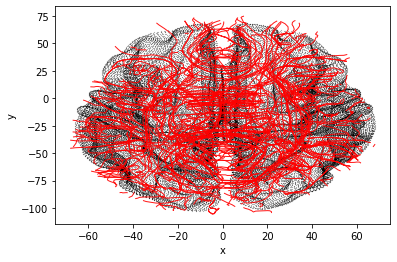

In [221]:
%%time

fig, ax = plt.subplots()#(subplot_kw={'projection': '3d'},figsize=(9,9))
for s in streamlines_ds_subset:
    x,y,z = s.T
    ax.plot(x,y,c='r',linewidth=1,alpha=0.9)
df_mt_vtx.plot(kind='scatter', x='x', y='y', ax=ax,s=0.05,marker='.',c='k')
df_r_mt_vtx.plot(kind='scatter', x='x', y='y', ax=ax,s=0.05,marker='.',c='k')

CPU times: user 997 ms, sys: 41.1 ms, total: 1.04 s
Wall time: 1.03 s


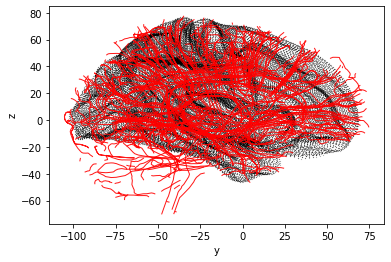

In [222]:
%%time

fig, ax = plt.subplots()#(subplot_kw={'projection': '3d'},figsize=(9,9))
for s in streamlines_ds_subset:
    x,y,z = s.T
    ax.plot(y,z,c='r',linewidth=1,alpha=0.9)
df_mt_vtx.plot(kind='scatter', x='y', y='z', ax=ax,s=0.05,marker='.',c='k')
df_r_mt_vtx.plot(kind='scatter', x='y', y='z', ax=ax,s=0.05,marker='.',c='k')

CPU times: user 1.21 s, sys: 123 ms, total: 1.34 s
Wall time: 1.33 s


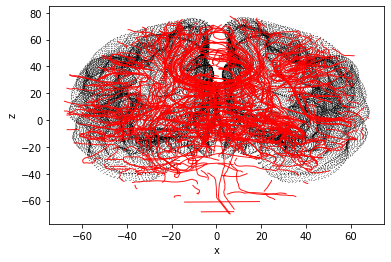

In [223]:
%%time

fig, ax = plt.subplots()#(subplot_kw={'projection': '3d'},figsize=(9,9))
for s in streamlines_ds_subset:
    x,y,z = s.T
    ax.plot(x,z,c='r',linewidth=1,alpha=0.9)
df_mt_vtx.plot(kind='scatter', x='x', y='z', ax=ax,s=0.05,marker='.',c='k')
df_r_mt_vtx.plot(kind='scatter', x='x', y='z', ax=ax,s=0.05,marker='.',c='k')

In [41]:
#  Specify the path to the .annot file
annot_file = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/PyTepFit/Data/fs_directory/151526/mri/151526_Schaefer2018_400Parcels_7Networks_rewritten.nii.gz'

# Load the .annot file
annot_img = nib.load(annot_file)

# Access the data from the .annot file
annot_data = annot_img.get_data()

In [193]:
annot_data.shape

(256, 256, 256)

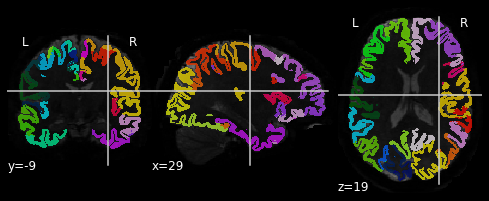

In [42]:
from nilearn import plotting as nplot


nplot.plot_roi(annot_img, dwi_img.slicer[:, :, :, 0])


In [49]:
affine=np.eye(4)

In [194]:
%%time
conn_mat, grouping = utils.connectivity_matrix(streamlines,
                                               b0_img.affine,
                                               annot_data,
                                               return_mapping=True,
                                               mapping_as_streamlines=True)

CPU times: user 10.2 s, sys: 1.46 s, total: 11.7 s
Wall time: 12.2 s


In [195]:
conn_mat = conn_mat[1:, 1:]

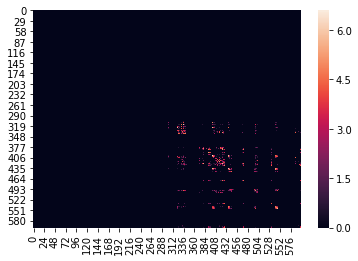

In [196]:
sns.heatmap(np.log1p(conn_mat))

In [54]:
type(annot_data)

numpy.ndarray

In [62]:
annot_data.shape

(256, 256, 256)

In [63]:
type(annot_data)

numpy.ndarray

In [64]:
type(nbm_dat)

numpy.ndarray

In [65]:
nbm_dat.shape

(145, 174, 145)

In [67]:
np.unique(nbm_dat)

array([0., 1.], dtype=float32)

### trial x

In [95]:
# Following the "fitting" of the label to mask using the notes in 
# http://localhost:8893/edit/Code/whobpyt/fit_label_to_mask_dwi.txt ...

# Update: attempt failed!

### trial y

In [ ]:
# /external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/PyTepFit/Data/fs_directory/151526/mri/151526_Schaefer2018_400Parcels_7Networks_rewritten.nii.gz 
# /external/rprshnas01/public_datasets/HCP/HCP_S900/151526/T1w/Diffusion/nodif_brain_mask.nii.gz 

In [182]:
# Load the label file and brain mask file
label_file_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/PyTepFit/Data/fs_directory/151526/mri/151526_Schaefer2018_400Parcels_7Networks_rewritten.nii.gz'
mask_file_path = '/external/rprshnas01/public_datasets/HCP/HCP_S900/151526/T1w/Diffusion/nodif_brain_mask.nii.gz'

label_img = nib.load(label_file_path)
mask_img = nib.load(mask_file_path)

In [183]:
# Get the label and mask data as numpy arrays
label_data = label_img.get_fdata().astype(np.int32)
mask_data = mask_img.get_fdata().astype(np.int32)

# Get the dimensions of the label file
label_dims = label_data.shape

# Get the dimensions of the mask file
mask_dims = mask_data.shape

In [186]:
# Crop the label data to match the mask dimensions
cropped_label_data = label_data[
    :mask_dims[0], :mask_dims[1], :mask_dims[2]
]

In [252]:
%%time
conn_mat, grouping = utils.connectivity_matrix(streamlines,
                                               b0_img.affine,
                                               cropped_label_data,
                                               return_mapping=True,
                                               mapping_as_streamlines=True)

CPU times: user 10.1 s, sys: 1.35 s, total: 11.4 s
Wall time: 11.4 s


In [190]:
conn_mat = conn_mat[1:, 1:]

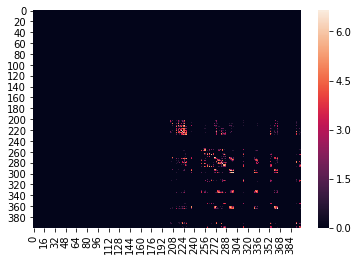

In [191]:
sns.heatmap(np.log1p(conn_mat))

In [228]:
import numpy as np
from scipy.ndimage.morphology import binary_dilation

from dipy.data import read_stanford_labels, read_stanford_t1
from dipy.direction import peaks
from dipy.reconst import shm
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion
from dipy.tracking.streamline import Streamlines

In [229]:
hardi_img, gtab, labels_img = read_stanford_labels()
data = hardi_img.get_data()
labels = labels_img.get_data()

t1 = read_stanford_t1()
t1_data = t1.get_data()

In [231]:
labels.shape

(81, 106, 76)

In [232]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86,
       87, 88], dtype=uint8)

In [233]:
#  Specify the path to the .annot file
annot_file = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/PyTepFit/Data/fs_directory/151526/mri/151526_Schaefer2018_400Parcels_7Networks_rewritten.nii.gz'

# Load the .annot file
annot_img = nib.load(annot_file)

# Access the data from the .annot file
annot_data = annot_img.get_data()

In [240]:
nbm_dat.shape

(145, 174, 145)

In [235]:
annot_data.shape

(256, 256, 256)

In [236]:
np.unique(annot_data)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [256]:
len(np.unique(annot_data))

401

In [237]:
pwd

'/external/rprshnas01/kcni/hharita/Code/whobpyt/Intro_to_dMRI_workshop'

In [265]:
resampled_label_dat = nilearn.image.resample_img(annot_file, target_affine=nbm_img.affine, target_shape=target_shape,interpolation='nearest')

In [267]:
resampled_label_dat.shape

(145, 174, 145)

In [269]:
resampled_label_data = resampled_label_dat.get_data()

In [271]:
resampled_label_data.shape

(145, 174, 145)

In [272]:
np.unique(resampled_label_data)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [273]:
%%time
conn_mat, grouping = utils.connectivity_matrix(streamlines,
                                               b0_img.affine,
                                               resampled_label_data,
                                               return_mapping=True,
                                               mapping_as_streamlines=True)

CPU times: user 9.87 s, sys: 1.29 s, total: 11.2 s
Wall time: 11.2 s


In [274]:
conn_mat = conn_mat[1:, 1:]

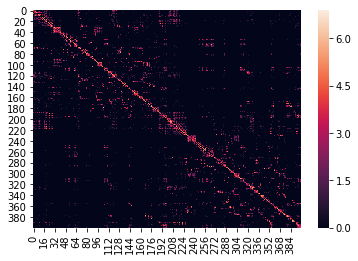

In [275]:
sns.heatmap(np.log1p(conn_mat))